[Labeled Faces In The Wild](http://vis-www.cs.umass.edu/lfw/) using sklearn, mostly inspired from [Faces recognition example using eigenfaces and SVMs](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py)

In [1]:
import numpy as np
from scipy.stats import uniform, randint
from time import time
import pandas as pd

# plot
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# dataset
from sklearn.datasets import fetch_lfw_people, make_classification

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# result metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

# ensemble meta-classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

### Global parameters

In [2]:
TEST_SIZE = 0.2

### Preprocess dataset

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [4]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, height, width = lfw_people.images.shape
print(lfw_people.images.shape)

(1288, 50, 37)


In [5]:
X = lfw_people.data
n_features = X.shape[1] #height*width

In [6]:
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [7]:
print("Total dataset size:")
print("\tn_samples: %d" % n_samples)
print("\t   height: %d" % height)
print("\t   width: %d" % width)
print("\tn_features: %d" % n_features)
print("\tn_classes: %d" % n_classes)

Total dataset size:
	n_samples: 1288
	   height: 50
	   width: 37
	n_features: 1850
	n_classes: 7


In [8]:
X = StandardScaler().fit_transform(X)
dataset_split = train_test_split(X, y, test_size=TEST_SIZE)
X_train, X_test, y_train, y_test = dataset_split

## Unsupervised feature extraction: PCA

In [9]:
N_COMPONENTS = 150

In [10]:
print("Extracting the top %d eigenfaces from %d faces"
      % (N_COMPONENTS, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=N_COMPONENTS, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((N_COMPONENTS, height, width))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
dataset_split_pca = X_train_pca, X_test_pca, y_train, y_test
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 1030 faces
done in 0.088s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.025s


## Helper plot functions

In [11]:
def plot_gallery(images, titles, height, width, n_row=3, n_col=4):
    """
    Helper function to plot a gallery of portraits
    """
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title_image(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

def plot_gallery_result(X_test, y_test, y_pred, show_eigenfaces=True):
    prediction_titles = [title_image(y_pred, y_test, target_names, i)
                             for i in range(y_pred.shape[0])]

    plot_gallery(X_test, prediction_titles, height, width)

    if show_eigenfaces:
        # plot the gallery of the most significative eigenfaces
        eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
        plot_gallery(eigenfaces, eigenface_titles, height, width)

    plt.show()

In [12]:
def plot_train_info(df):
    """
    Helper to sort performance by out-of-sample accuracy and draw a bar plot
    """
    df = df.set_index('classifier')
    df.drop('train_time', axis=1)\
        .sort_values('out_accuracy', ascending=False)\
        .plot(kind="bar", stacked=False, figsize=(8,5))
    df.drop(['in_accuracy', 'out_accuracy'], axis=1)\
        .sort_values('train_time', ascending=False)\
        .plot(kind="bar", stacked=False, figsize=(8,5))
    
def compare_classifiers_plot(dataset_split, classifiers, clf_names):
    """
    Plot decision boundaries for a set of classifiers and compare their respective accuracies
    """
    X_train, X_test, y_train, y_test = dataset_split
    
    info = []
    
    for (i, (clf_name, clf)) in enumerate(zip(clf_names, classifiers)):
        # timer for training
        t0 = time()
        clf.fit(X_train, y_train)
        train_time = time()-t0
        
        y_pred_in = clf.predict(X_train)
        y_pred = clf.predict(X_test)

        in_acc = accuracy_score(y_train, y_pred_in)
        out_acc = accuracy_score(y_test, y_pred)

        info.append({
            'classifier': clf_name,
            'in_accuracy': in_acc,
            'out_accuracy': out_acc,
            'train_time': train_time
            }
        )
        
        print('-----{}-----'.format(clf_name))
        print(classification_report(y_test, y_pred, target_names=target_names))
        
    df = pd.DataFrame(info) 
    plot_train_info(df)
        
    return df

def plot_classifiers_gallery(X_test, X_test_pca, y_test, classifiers, clf_names, show_eigenfaces=True):
    """
    Plot gallery of predicted faces
    """
    for (i, (clf_name, clf)) in enumerate(zip(clf_names, classifiers)):
        y_pred = clf.predict(X_test_pca)
        print('-----{}-----'.format(clf_name))
        plot_gallery_result(X_test, y_test, y_pred, show_eigenfaces=show_eigenfaces)

### Classifiers

In [13]:
MIN_SAMPLE_LEAF = 1
MAX_DEPTH = 20
MAX_LEAF_NODES= 24
N_ESTIMATORS = 500
MAX_SAMPLES = 100
N_ITER_SEARCH = 10
CV = 5

In [14]:
log_clf = LogisticRegression(solver='lbfgs', multi_class='auto')

knn_clf = RandomizedSearchCV(
    KNeighborsClassifier(
        weights='distance', 
        n_jobs=-1
    ),
    param_distributions={'n_neighbors': randint(1,30)},
    n_iter=N_ITER_SEARCH, 
    cv=CV,
    iid=False,
)

decision_tree_clf = DecisionTreeClassifier(
    max_leaf_nodes=MAX_LEAF_NODES, 
    max_depth=MAX_DEPTH, 
    min_samples_leaf=MIN_SAMPLE_LEAF
)

random_forest_clf = RandomForestClassifier(
    n_estimators=N_ESTIMATORS, 
    max_leaf_nodes=MAX_LEAF_NODES, 
    n_jobs=-1
) # n_jobs=-1 : use all available CPU cores

# use cross-validated version in ordere to predict probabilities as well
lin_svm_clf = CalibratedClassifierCV(
    base_estimator=LinearSVC(),
    cv=CV
)

sigm_svm_clf = RandomizedSearchCV(
    SVC(
        kernel='sigmoid',
        gamma='scale',
        probability=True
    ),
    param_distributions={'coef0': uniform(0,6)},
    n_iter=N_ITER_SEARCH, 
    cv=CV,
    iid=False,
)

rbf_svm_clf = CalibratedClassifierCV(
    SVC(
        kernel='rbf',
        gamma='scale',
        probability=True
    ),
    cv=CV
)

In [15]:
classifiers = [
    log_clf,
    lin_svm_clf,
    #sigm_svm_clf,
    rbf_svm_clf,
    knn_clf,
    decision_tree_clf,
    random_forest_clf,
]

clf_names = [
    'Logistic Regression',
    'Linear SVM',
    #'Sigmoid SVM',
    'Gaussian SVM',
    'KNN',
    'Decision Tree',
    'Random Forest',
]

best_classifiers = [
    rbf_svm_clf,
    random_forest_clf,
]

best_clf_names = [
    'Gaussian SVM',
    'Random Forest',
]

### Ensemble Classifiers

In [16]:
decision_tree_bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes=MAX_LEAF_NODES, max_depth=MAX_DEPTH, min_samples_leaf=MIN_SAMPLE_LEAF),
    n_estimators=N_ESTIMATORS,
    max_samples=MAX_SAMPLES,
    bootstrap=True,
    n_jobs=-1,
)

# all classifiers get to vote
demo_soft_voting_clf = VotingClassifier(
    estimators=list(zip(clf_names, classifiers)),
    voting='soft',
)

# only rbf_svm and random forests get to vote
oli_soft_voting_clf = VotingClassifier(
    estimators=list(zip(best_clf_names, best_classifiers)),
    voting='soft',
)

decision_tree_ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_leaf_nodes=MAX_LEAF_NODES, max_depth=MAX_DEPTH, min_samples_leaf=MIN_SAMPLE_LEAF),
    n_estimators=N_ESTIMATORS,
    algorithm='SAMME.R',
    learning_rate=0.5,
)

In [17]:
ens_classifiers = [
    demo_soft_voting_clf,
    oli_soft_voting_clf,
    decision_tree_bag_clf,
    decision_tree_ada_clf
]

ens_clf_names = [
    'Democratic Soft Voting',
    'Oligarchic Soft Voting',
    'Decision Tree Bagging',
    'Decision Tree Boosting',
]

## Compare them all

In [18]:
all_classifiers = classifiers+ens_classifiers
all_clf_names = clf_names+ens_clf_names

-----Logistic Regression-----
                   precision    recall  f1-score   support

     Ariel Sharon       0.80      0.73      0.76        11
     Colin Powell       0.74      0.79      0.76        47
  Donald Rumsfeld       0.75      0.75      0.75        16
    George W Bush       0.90      0.89      0.89       115
Gerhard Schroeder       0.79      0.92      0.85        24
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.78      0.83      0.81        30

        micro avg       0.83      0.83      0.83       258
        macro avg       0.81      0.78      0.78       258
     weighted avg       0.83      0.83      0.83       258



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

-----Linear SVM-----
                   precision    recall  f1-score   support

     Ariel Sharon       0.80      0.73      0.76        11
     Colin Powell       0.76      0.81      0.78        47
  Donald Rumsfeld       0.73      0.69      0.71        16
    George W Bush       0.83      0.92      0.87       115
Gerhard Schroeder       0.95      0.75      0.84        24
      Hugo Chavez       0.91      0.67      0.77        15
       Tony Blair       0.84      0.70      0.76        30

        micro avg       0.82      0.82      0.82       258
        macro avg       0.83      0.75      0.79       258
     weighted avg       0.83      0.82      0.82       258

-----Gaussian SVM-----
                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.82      0.82        11
     Colin Powell       0.89      0.89      0.89        47
  Donald Rumsfeld       1.00      0.62      0.77        16
    George W Bush       0.82      0.96      0.88       115
Gerhard 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number 

-----Democratic Soft Voting-----
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.82      0.90        11
     Colin Powell       0.78      0.85      0.82        47
  Donald Rumsfeld       0.80      0.75      0.77        16
    George W Bush       0.83      0.92      0.88       115
Gerhard Schroeder       1.00      0.88      0.93        24
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.92      0.77      0.84        30

        micro avg       0.85      0.85      0.85       258
        macro avg       0.89      0.80      0.84       258
     weighted avg       0.86      0.85      0.85       258

-----Oligarchic Soft Voting-----
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.82      0.90        11
     Colin Powell       0.87      0.87      0.87        47
  Donald Rumsfeld       1.00      0.62      0.77        16
    George W Bush       0.77      0.97      0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-----Decision Tree Boosting-----
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        11
     Colin Powell       0.80      0.43      0.56        47
  Donald Rumsfeld       0.00      0.00      0.00        16
    George W Bush       0.48      0.98      0.65       115
Gerhard Schroeder       0.00      0.00      0.00        24
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.00      0.00      0.00        30

        micro avg       0.52      0.52      0.52       258
        macro avg       0.18      0.20      0.17       258
     weighted avg       0.36      0.52      0.39       258



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


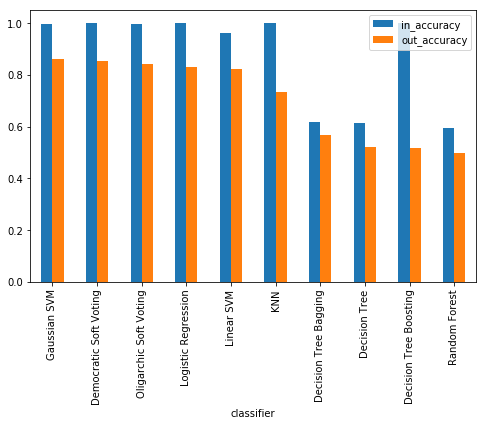

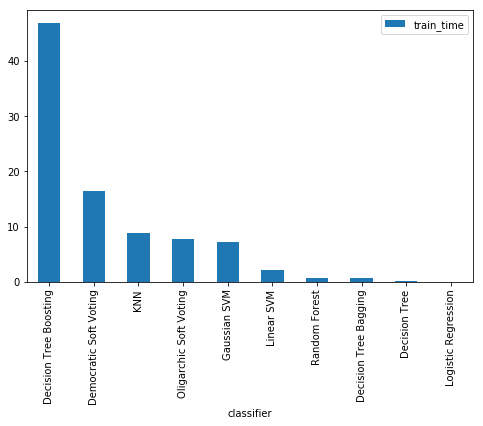

In [19]:
df = compare_classifiers_plot(dataset_split_pca, all_classifiers, all_clf_names)

-----RBF SVM-----


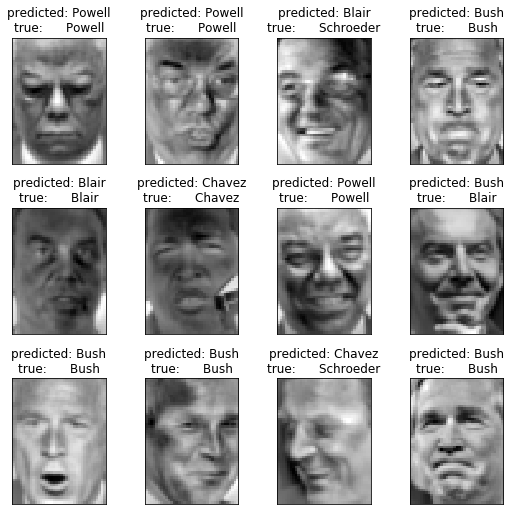

In [20]:
# uncomment to see galery for all classifiers
#plot_classifiers_gallery(X_test, X_test_pca, y_test, classifiers, clf_names, show_eigenfaces=False)
plot_classifiers_gallery(X_test, X_test_pca, y_test, [rbf_svm_clf], ['RBF SVM'], show_eigenfaces=False)